In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from arch import arch_model
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Download NIFTY 50 data
nifty = yf.download("^NSEI", start="2020-01-01", end="2025-04-15", group_by = "ticker")["^NSEI"]

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [3]:
nifty

Price,Open,High,Low,Close,Volume
Date,,,,,
2020-01-01,12202.150391,12222.200195,12165.299805,12182.500000,304100
2020-01-02,12198.549805,12289.900391,12195.250000,12282.200195,407700
2020-01-03,12261.099609,12265.599609,12191.349609,12226.650391,428800
2020-01-06,12170.599609,12179.099609,11974.200195,11993.049805,396500
2020-01-07,12079.099609,12152.150391,12005.349609,12052.950195,447800
...,...,...,...,...,...
2025-04-04,23190.400391,23214.699219,22857.449219,22904.449219,466800
2025-04-07,21758.400391,22254.000000,21743.650391,22161.599609,647100
2025-04-08,22446.750000,22697.199219,22270.849609,22535.849609,468300


In [4]:
# Calculate daily log returns
nifty['LogReturn'] = np.log(nifty['Close'] / nifty['Close'].shift(1))
returns = nifty['LogReturn'].dropna() * 100  # Scale for GARCH model

In [5]:
# Step 3: Rolling Forecast
rolling_window = 500  # number of observations to train each time
forecast_horizon = 1  # how far ahead to forecast

forecast_vol = []

# Create rolling forecast
for i in tqdm(range(rolling_window, len(returns))):
    train_data = returns.iloc[i - rolling_window:i]
    model = arch_model(train_data, vol='GARCH', p=1, q=1, o=1)
    model_fitted = model.fit(disp='off')
    forecast = model_fitted.forecast(horizon=forecast_horizon)
    vol_forecast = np.sqrt(forecast.variance.values[-1, :][0])  # daily vol
    forecast_vol.append(vol_forecast)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 805/805 [00:26<00:00, 30.36it/s]


In [6]:
# Step 4: Prepare forecast series aligned with dates
forecast_dates = returns.index[rolling_window:]
forecast_series = pd.Series(forecast_vol, index=forecast_dates)
annualized_forecast = forecast_series * np.sqrt(252)


In [7]:
# Step 5: Calculate actual realized daily volatility (5-day rolling std)
realized_vol = returns.rolling(window=5).std().loc[forecast_dates]  # 5-day window for smoothing
annualized_realized = realized_vol * np.sqrt(252)


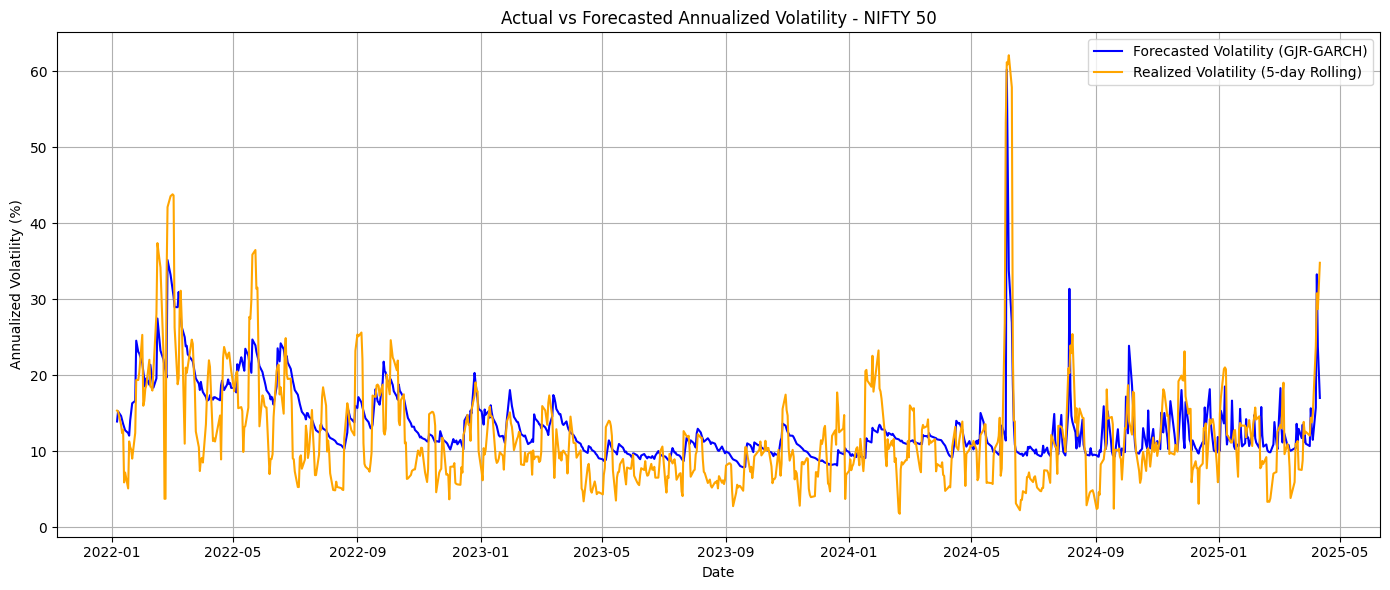

In [8]:
# Step 6: Plot actual vs forecasted volatility
plt.figure(figsize=(14, 6))
plt.plot(annualized_forecast.index, annualized_forecast, label='Forecasted Volatility (GJR-GARCH)', color='blue')
plt.plot(annualized_realized.index, annualized_realized, label='Realized Volatility (5-day Rolling)', color='orange')
plt.title('Actual vs Forecasted Annualized Volatility - NIFTY 50')
plt.xlabel('Date')
plt.ylabel('Annualized Volatility (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:
actual_vix = pd.read_csv("hist_india_vix_-01-01-2024-to-31-12-2024.csv", index_col = 0, parse_dates = True)

C:\Users\academy\AppData\Local\Temp\ipykernel_11372\4273346627.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  actual_vix = pd.read_csv("hist_india_vix_-01-01-2024-to-31-12-2024.csv", index_col = 0, parse_dates = True)


In [10]:
actual_vix.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 250 entries, 2024-01-01 to 2024-12-31
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          250 non-null    float64
 1   High          250 non-null    float64
 2   Low           250 non-null    float64
 3   Close         250 non-null    float64
 4   Prev. Close   250 non-null    float64
 5   Change        250 non-null    float64
 6   % Change      250 non-null    float64
dtypes: float64(7)
memory usage: 15.6 KB


In [11]:
combined = pd.concat([annualized_forecast, annualized_realized], axis=1).dropna()
combined.columns = ['Forecasted', 'Realized']

# Calculate correlation
correlation = combined.corr().iloc[0, 1]
print(f"Correlation between Forecasted and Realized Volatility: {correlation:.4f}")

Correlation between Forecasted and Realized Volatility: 0.7443
